# Tutorial - Sheet Model Illustration

This notebook contains some code snippets + illustrations of one iteration of the Sheet Model Synchronous algorithm. 

The full implementation is explained in more detail in Appendix A of [Do Graph Neural Networks Dream of Landau Damping? Insights from Kinetic Simulations of a Plasma Sheet Model](https://arxiv.org/abs/2310.17646).

For details regarding the usage of the full Sheet Model simulator check the [companion notebook](Sheet_Model_Async&Sync.ipynb).

In [1]:
import os
import sys
import glob
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../..')
from sheet_model.synchronous import SyncSheetModel
from sheet_model.utils import get_dx_eq, get_x_eq

We will be showing what happens to an hypotethical system of 4 sheets in between $t  \rightarrow t + \Delta t$ when crossings occurs.

In [2]:
opt = {
    'n_sheets' : 4, # number of sheets
    ################# parameters below have dummy values (but are needed to initialize simulator)
    'n_guards' : 1, 
    'dt' : None, 
    'boundary' : 'periodic', 
    'n_it_crossings' : None,
    'track_sheets': False,
    'L': 1
}

dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])

x0 = x_eq # initial positions
v0 = np.array([0.7, 0.4, -0.7, 0]) # initial velocities

sim = SyncSheetModel(**opt) # aux simulator

In [3]:
def format_axis(a, xmin=-0.5, xmax=1.1): 
    "Aux function to format axis nicely"
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['left'].set_linewidth(2)
    a.spines['bottom'].set_linewidth(2)

    # define axis limits
    ymin, ymax = 0, dt + 0.2
    a.set_xlim(xmin, xmax)
    a.set_ylim(ymin, 
               ymax)

    # add arrow at the end of axis
    a.plot(0, ymax, "^k", transform=a.get_yaxis_transform(), ms=10, clip_on=False)
    a.plot(xmax, 0, ">k", transform=a.get_xaxis_transform(), ms=10, clip_on=False)

    # custom ticks
    a.xaxis.set_ticks([])
    a.yaxis.set_ticks([0, dt])
    a.yaxis.set_ticklabels(['$t$', '$t + \Delta t$'], fontsize=35)
    a.tick_params(axis='y', which='minor', left=False, right=False)
    a.tick_params(axis='y', which='major', right=False)

    a.set_xlabel('$x$', fontsize=35)

For the chosen initial conditions, we can see below what would be the sheet positions at $t + \Delta t$ without correcting for crossings.

The dotted lines would not actually be computed by the algorithm, they are shown only for illustration purposes.

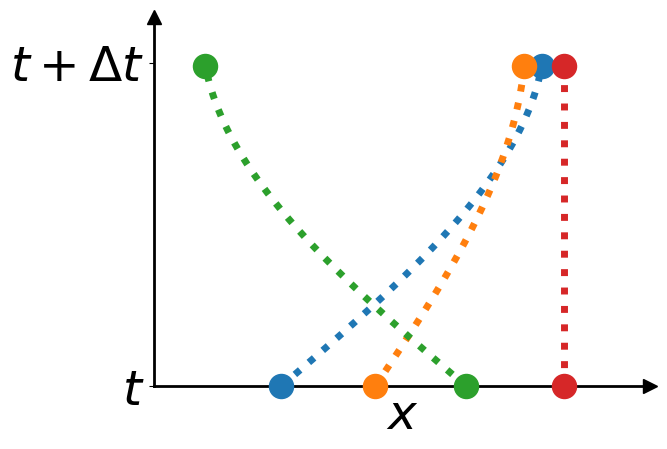

In [4]:
dt_highres = 0.01 # finer time-step for higher resolution trajectory (aux for plotting)
dt = np.pi/4 * 1.8 # (real) simulation time-step

# higher resolution traje for illustration purposes
X, V = [], []
x, v = x0.copy(), v0.copy()
for i in range(int(dt//dt_highres)):
    x,v = sim._advance_eom(x_i=x, v_i=v, x_eq_i=x_eq, dt=dt_highres)
    X.append(x)
    V.append(v)
    
X = np.array(X)
V = np.array(V)
t = np.arange(len(X)) * dt_highres


colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, ax = plt.subplots(1,1)
format_axis(ax, xmin=-0.2, xmax=1.1)

for i, x in enumerate(X.T):
    
    ax.plot(x, t, ':', color=colors[i], lw=5)
    ax.scatter([x[0], x[-1]], [t[0], t[-1]], s=300, zorder=np.inf, clip_on=False)
    

The crossing algorithm would then proceed to identify if sheets crossed each other. 
This happens in a serial fashion, from left to right. 

The first sheet is selected, and one checks for crossings with the sheets that were initially to its right (there is a stopping criteria, to avoid checking the full system, which is not covered here). 

The process is then repeated for all other sheets until we reach the second last.

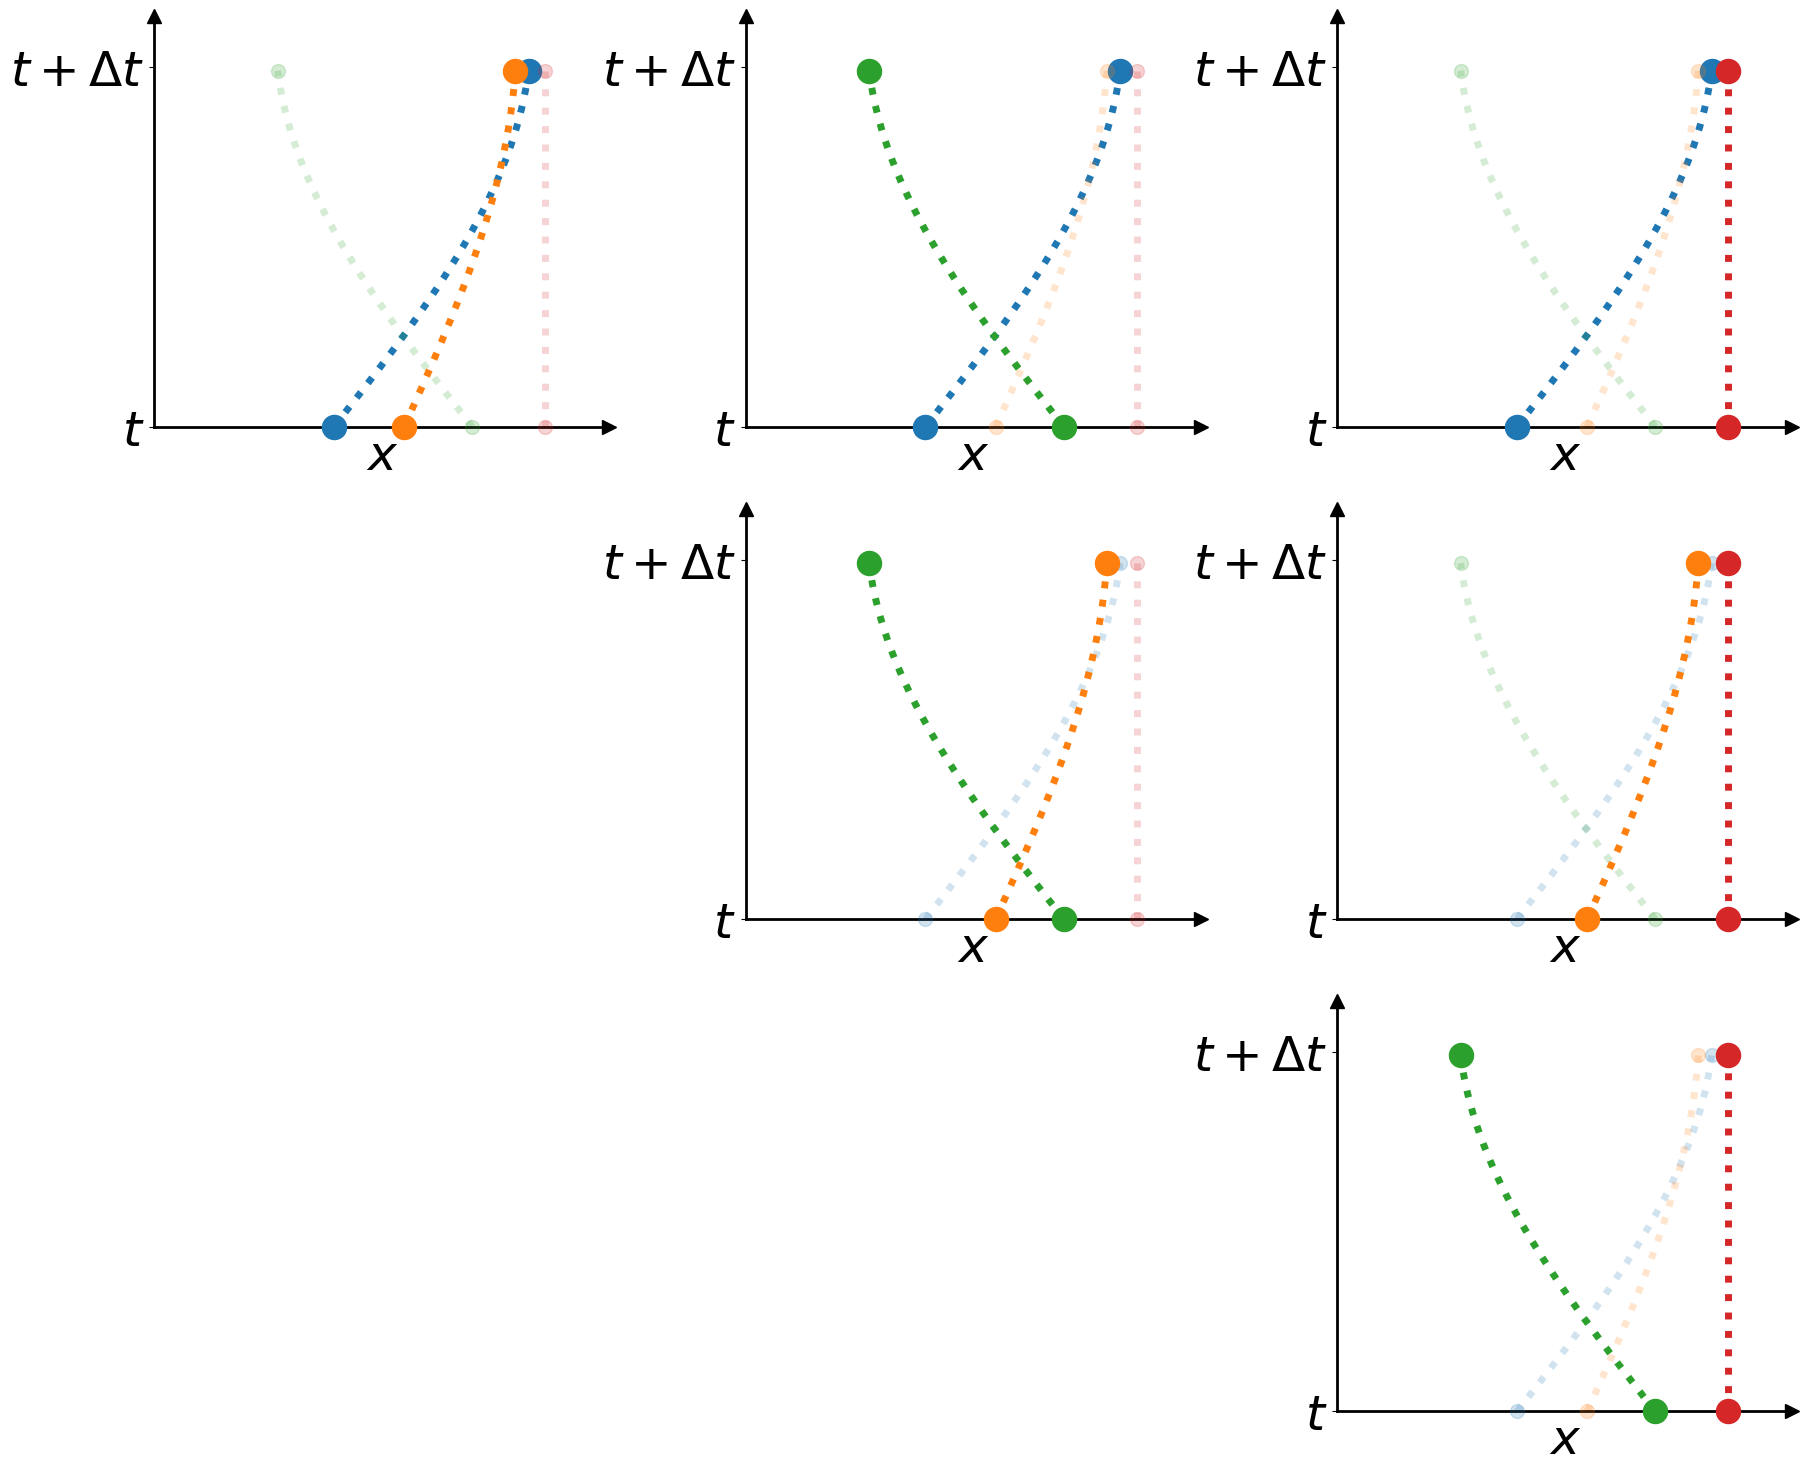

In [5]:
fig, ax = plt.subplots(3,3, figsize=(6*3, 5*3), 
                       gridspec_kw={'wspace': 0.3, 'top':0.98, 'bottom': 0.05,
                                    'left': 0.08, 'right': 0.99})
    
################################# axis
        
for i in range(3):
    for j in range(3):
        a = ax[i,j]
        
        if j >= i:
            format_axis(a, xmin=-0.5)
            
        else:
            a.set_axis_off()
    
################################# plots

for i in range(3):
    for j in range(i+1, 4):
        for ix, x in enumerate(X.T):
            ax[i,j-1].plot(x, t, ':', color=colors[ix], 
                         alpha=1 if ix in [i,j] else 0.2, 
                         lw=5)
            
            ax[i,j-1].scatter([x[0], x[-1]], [t[0], t[-1]], color=colors[ix], 
                            alpha=1 if ix in [i,j] else 0.2, 
                            s=300 if ix in [i,j] else 100, 
                            zorder=np.inf, clip_on=False)


plt.show()

For each detected crossing, an iterative method is used to estimate the crossing time. 

The number of iterations used corresponds to the parameter n_it_crossings in SyncSheetModel()

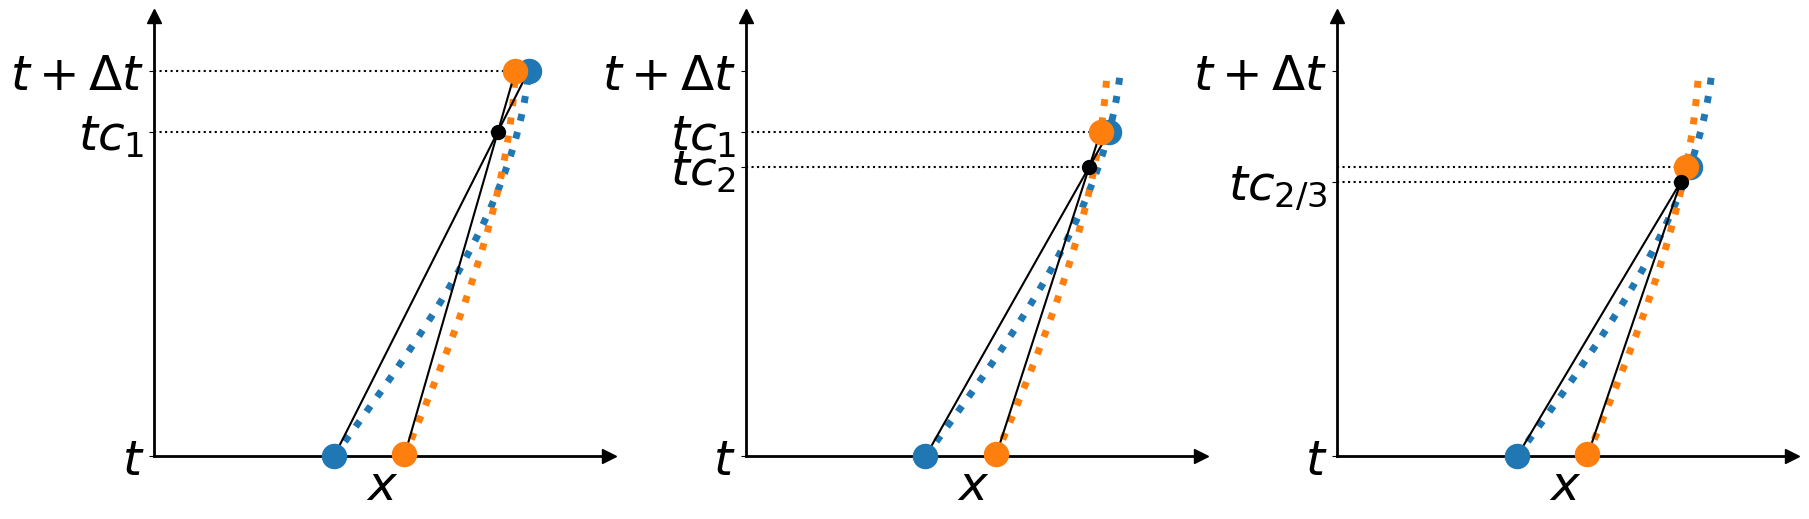

In [6]:
fig, ax = plt.subplots(1,3, figsize=(6*3, 5*1),
                       gridspec_kw={'wspace': 0.3, 'top':0.98, 'bottom': 0.10,
                                    'left': 0.08, 'right': 0.99})
    
################################# axis

xmin=-0.5
xmax=1.1
for ia, a in enumerate(ax.ravel()):
    format_axis(a, xmin=xmin, xmax=xmax)
    
################################# find crossing times

opt['dt'] = dt
TC = list()
pair = [0,1]

for n in range(1,4):
    
    opt['n_it_crossings'] = n
    sim = SyncSheetModel(**opt)

    tc = sim._get_crossing_time(x_i=X[0,pair],
                                v_i=V[0,pair],
                                x_f=X[-1,pair],
                                x_eq_i=x_eq[pair])
    
    TC.append(tc)


################################# plots

xi = X[0,pair]
xf = X[-1,pair]
tf = dt

for itc, tc in enumerate(TC):
    
    ax[itc].plot(X[:,pair[0]], t, ':', color=colors[pair[0]], lw=5)
    ax[itc].plot(X[:,pair[1]], t, ':', color=colors[pair[1]], lw=5)
    
    ax[itc].plot([xi, xf], [t[0], tf], 'k')
    
    ax[itc].scatter([xi[0], xf[0]], [t[0], tf], color=colors[pair[0]], 
                    s=300, zorder=np.inf, clip_on=False)
    ax[itc].scatter([xi[1], xf[1]], [t[1], tf], color=colors[pair[1]],
                    s=300, zorder=np.inf, clip_on=False)
    
    ax[itc].axhline(tf, xmax=(np.max(xf)-xmin)/(xmax-xmin), ls=':', color='k')
    
    if itc == 0: 
        ax[itc].yaxis.set_ticks([0, tc, dt])
        ax[itc].yaxis.set_ticklabels(['$t$', f'$tc_{itc+1}$', '$t + \Delta t$'])
    
    if itc == 1:
        ax[itc].yaxis.set_ticks([0, tc, tf, dt])
        ax[itc].yaxis.set_ticklabels(['$t$', f'$tc_{itc+1}$', f'$tc_{itc}$', '$t + \Delta t$'])
        
    if itc == 2:
        ax[itc].yaxis.set_ticks([0, tc, dt])
        ax[itc].yaxis.set_ticklabels(['$t$', '$tc_{2/3}$', '$t + \Delta t$'])
        
    xc = xi[0] + (xf[0] - xi[0])/tf * tc
    ax[itc].axhline(tc, xmax=(xc-xmin)/(xmax-xmin), ls=':', color='k')
    ax[itc].scatter([xc], [tc], color='k', zorder=np.inf, s=100)
    
    xf, _ = sim._advance_eom(x_i=X[0,pair], v_i=V[0,pair], x_eq_i=x_eq[pair], dt=tc)
    tf = tc


plt.show()

Based on the list of computed crossing times, the trajectories are then corrected by updating the sheet equilibrium positions at each crossing.

Below we do all the algorithm steps at once (detection + crossing time estimation + trajectory correction) in a similar fashion as it is implemented in SyncSheetModel().


#Sheet 0 tab:blue
Crossing Times [1.0076375872139762, 0.3555618041508023]
Crossing Rank [1, 1] (-1 from left, +1 from right)

#Sheet 1 tab:orange
Crossing Times [1.0076375872139762, 0.21931036411154264]
Crossing Rank [-1, 1] (-1 from left, +1 from right)

#Sheet 2 tab:green
Crossing Times [0.3555618041508023, 0.21931036411154264]
Crossing Rank [-1, -1] (-1 from left, +1 from right)


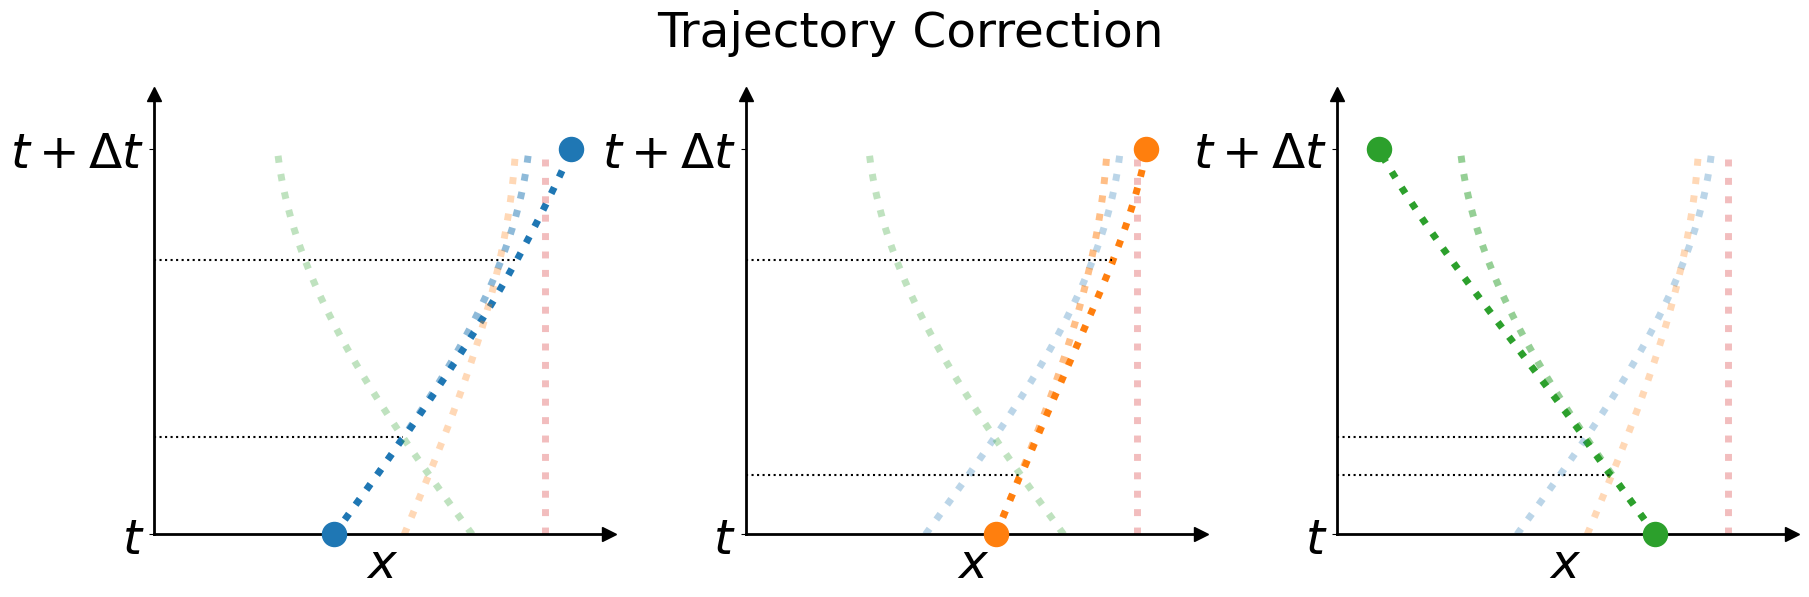

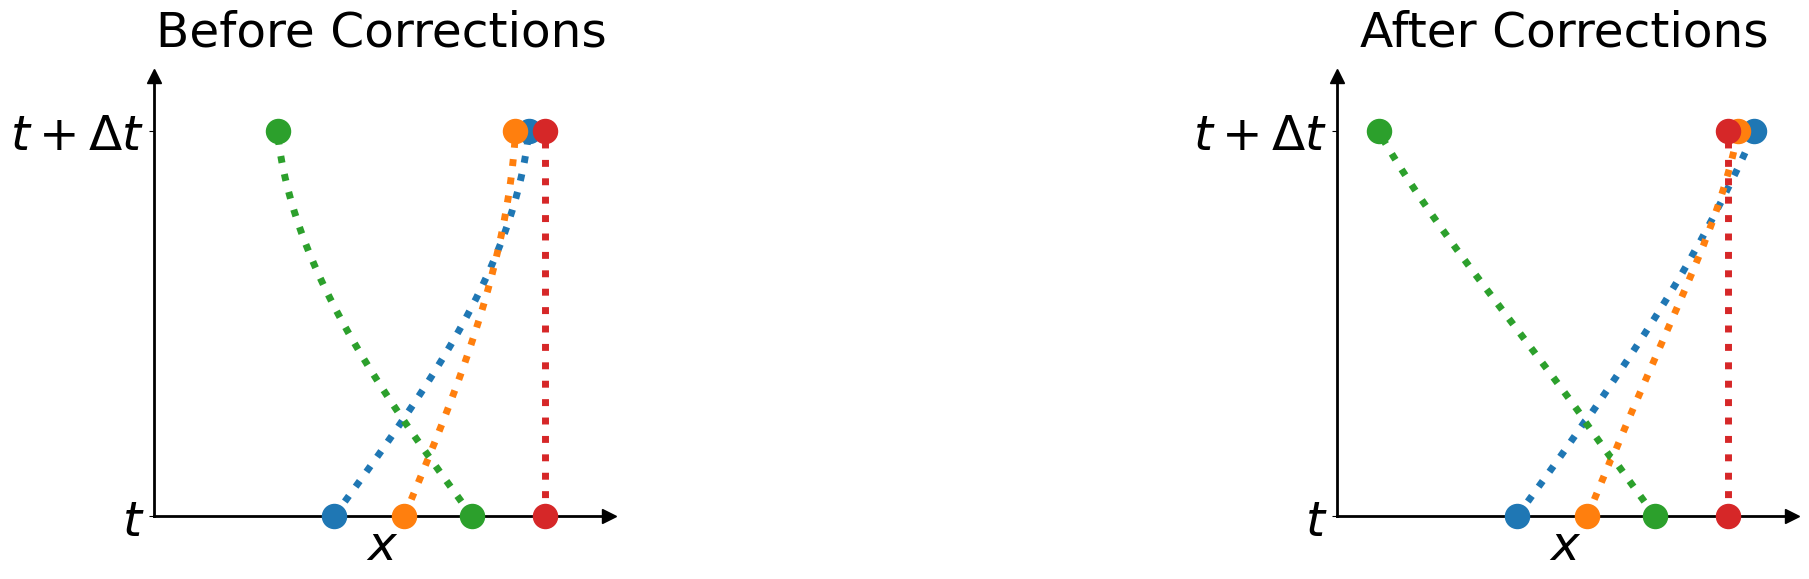

In [7]:
fig, ax = plt.subplots(1,3, figsize=(6*3, 5*1),
                       gridspec_kw={'wspace': 0.3, 'top':0.98, 'bottom': 0.10,
                                    'left': 0.08, 'right': 0.99})

fig2, ax2 = plt.subplots(1,3, figsize=(6*3, 5*1),
                         gridspec_kw={'wspace': 0.3, 'top':0.98, 'bottom': 0.10,
                                      'left': 0.08, 'right': 0.99})
    
################################# axis
        
for ia, a in enumerate(list(ax.ravel()) + list(ax2.ravel())):
    
    if ia != 4:
        format_axis(a, xmin=-0.5)
    else:
        a.set_axis_off()

################################# find crossings + estimate crossing time

x_i = X[0].copy()
v_i = V[0].copy()
x_eq_i = x_eq.copy()
x_f = X[-1].copy()
v_f = V[-1].copy()

# stores crossing times for each sheet
TCROSS = [[] for _ in range(len(x_f))]
# stores rank of crossings (+1 particles from left, -1 sheet from right)
RCROSS = [[] for _ in range(len(x_f))]

# estimate crossings times (from left to right)
for i in range(len(x_f) - 1):
    for j in range(i + 1, len(x_f)):
        # check if crossing occured
        if x_f[j] < x_f[i]:
            ##print('crossing')
            # estimate crossing time
            tc = sim._get_crossing_time(x_i=x_i[[i,j]],
                                        v_i=v_i[[i,j]],
                                        x_f=x_f[[i,j]],
                                        x_eq_i=x_eq_i[[i,j]])


            TCROSS[i].append(tc)
            TCROSS[j].append(tc)
            RCROSS[i].append(1)
            RCROSS[j].append(-1)
            

################################# correct trajectories + plot
for i in range(3):
    
    print()
    print('#Sheet', i, colors[i])
    print('Crossing Times', TCROSS[i])
    print('Crossing Rank', RCROSS[i], '(-1 from left, +1 from right)')
    
    if TCROSS[i]:
        
        # sort crossing times
        i_cross = np.argsort(TCROSS[i])
        t_cross = np.array(TCROSS[i])[i_cross]
        r_cross = np.array(RCROSS[i])[i_cross]
        
        t = 0
        x_c = x_i[i].copy()
        v_c = v_i[i].copy()
        x_eq_c = x_eq_i[i].copy()
        
        # high res trajectory
        XCORRECT = [x_i[i]]
        TCORRECT = [0]
        # low res trajectory
        xt = [x_i[i].copy()]
        tt = [0]
        
        for t_c, r_c in zip(t_cross, r_cross):
            
            # high res trajectory tc_i -> tc_i+1
            x_aux = x_c.copy()
            v_aux = v_c.copy()
            for t_aux in np.arange((t//dt_highres + 1)*dt_highres, t_c, dt_highres):
                x_aux, v_aux = sim._advance_eom(x_i=x_aux, v_i=v_aux, x_eq_i=x_eq_c, dt=dt_highres)
                TCORRECT.append(t_aux)
                XCORRECT.append(x_aux)
            
            # low res trajectory tc_i -> tc_i+1
            x_c, v_c = sim._advance_eom(x_c, v_c, x_eq_c, t_c - t)
            x_eq_c += r_c * sim.dx_eq
            t = t_c
            
            # low res trajectory
            xt.append(x_c)
            tt.append(t_c)
        
        # high res trajectory tc_max -> t + dt
        x_aux = x_c.copy()
        v_aux = v_c.copy()
        for t_aux in np.arange((t//dt_highres + 1)*dt_highres, dt, dt_highres):
            x_aux, v_aux = sim._advance_eom(x_i=x_aux, v_i=v_aux, x_eq_i=x_eq_c, dt=dt_highres)
            TCORRECT.append(t_aux)
            XCORRECT.append(x_aux)
        
        # low res trajectory tc_max -> t + dt
        x_f, v_f = sim._advance_eom(x_c, v_c, x_eq_c, dt - t_c)
        xt.append(x_f)
        tt.append(dt)
        
        ########################## fig 1
        # plot high res new trajectory
        ax[i].plot(XCORRECT, TCORRECT, ':', color=colors[i], lw=5)
        
        # plot start/end markers
        ax[i].scatter([xt[0], xt[-1]], [tt[0], tt[-1]], color=colors[i], s=300, clip_on=False, zorder=np.inf)
        
        # plot crossing times
        for tci, xci in zip(tt[1:-1], xt[1:-1]):
            ax[i].axhline(tci, xmax=(xci-xmin)/(xmax-xmin), ls=':', color='k')
    
        # plot old trajctories (all sheets)
        for k in range(4):
            ax[i].plot(X[:,k], np.arange(len(X)) * dt_highres, ':', color=colors[k], lw=5, 
                       alpha=0.3 if i!=k else 0.5)
        
        
        ########################## fig 2
        # plot high res trajectories
        ax2[0].plot(X[:,i], np.arange(len(X)) * dt_highres, ':', color=colors[i], lw=5)
        ax2[2].plot(XCORRECT, TCORRECT, ':', color=colors[i], lw=5)
        # plot high res trajectories
        ax2[0].scatter([X[0,i], X[-1,i]], [tt[0], tt[-1]], color=colors[i], s=300, clip_on=False, zorder=np.inf)
        ax2[2].scatter([xt[0], xt[-1]], [tt[0], tt[-1]], color=colors[i], s=300, clip_on=False, zorder=np.inf)
        

fig.suptitle('Trajectory Correction', fontsize=35, y=1.15)

ax2[0].plot(X[:,3], np.arange(len(X)) * dt_highres, ':', color=colors[3], lw=5)
ax2[0].scatter([X[0,3], X[-1,3]], [tt[0], tt[-1]], color=colors[3], s=300, clip_on=False, zorder=np.inf)
ax2[2].plot(X[:,3], np.arange(len(X)) * dt_highres, ':', color=colors[3], lw=5)
ax2[2].scatter([X[0,3], X[-1,3]], [tt[0], tt[-1]], color=colors[3], s=300, clip_on=False, zorder=np.inf)

ax2[0].set_title('Before Corrections', fontsize=35, y=1.05)
ax2[2].set_title('After Corrections', fontsize=35, y=1.05)

plt.show()